In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

In [2]:
sys.path.append('..')

In [3]:
def coverage_age(p,e):
    return (1 +((1-e)*((1/p) -1)))**-1

In [4]:
def error_coverage_age(p,e):
    var = (1-e)/((e*(p-1) + 1)**2)
    return np.sqrt(var)

# Calculating $S_0$: first method

- Using ignored data as vaccinated
- Using stratified population, grouping since it is our only option now

We will do this by:
- Calculating $P(V_i|S_i)$ with its error
- Propagating to get $c_i$ with its error
- Propagating to get $S_0$ with its error

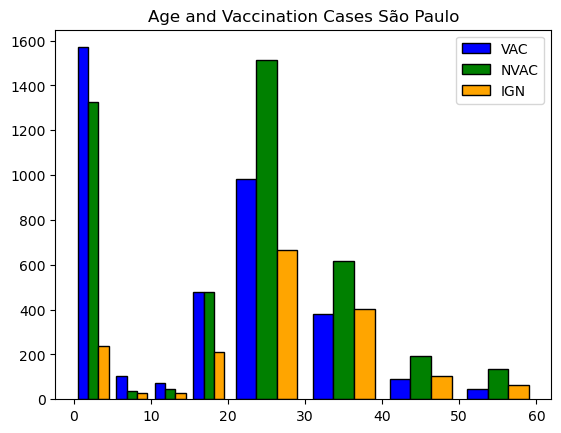

Considering ignored are vaccinated
564065.9431631977 39772.754960687045
EXCLUDING IGNORED FROM SAMPLE
884570.7442609104 49532.94766682978


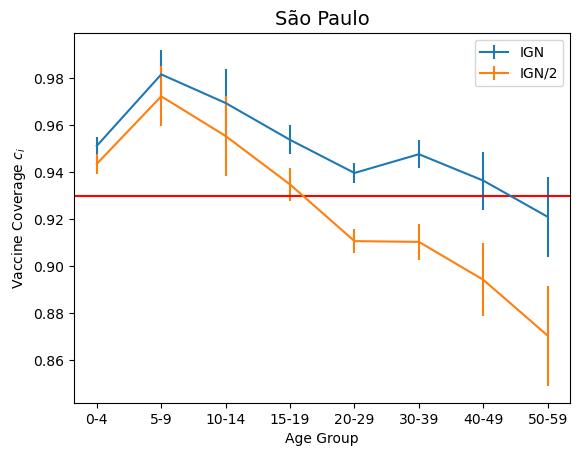

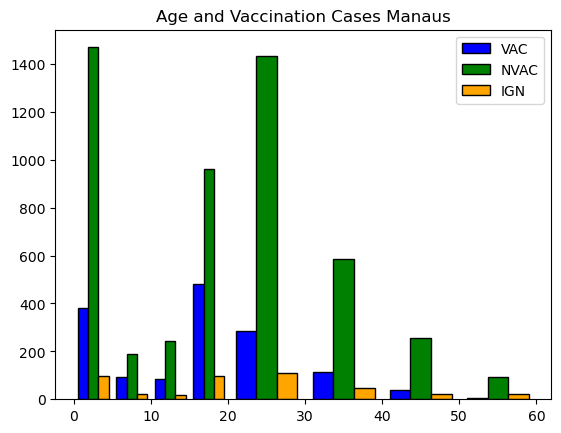

Considering ignored are vaccinated
367909.48535916395 13458.869233619047
EXCLUDING IGNORED FROM SAMPLE
443393.25504256407 14704.22531948592


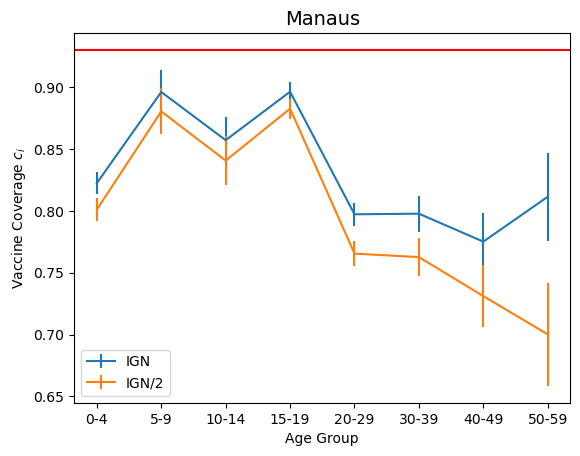

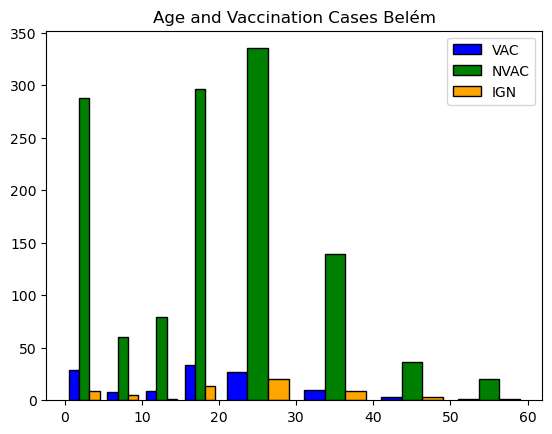

Considering ignored are vaccinated
430950.02888518036 28082.518554591443
EXCLUDING IGNORED FROM SAMPLE
507128.0297648035 29047.357922699335


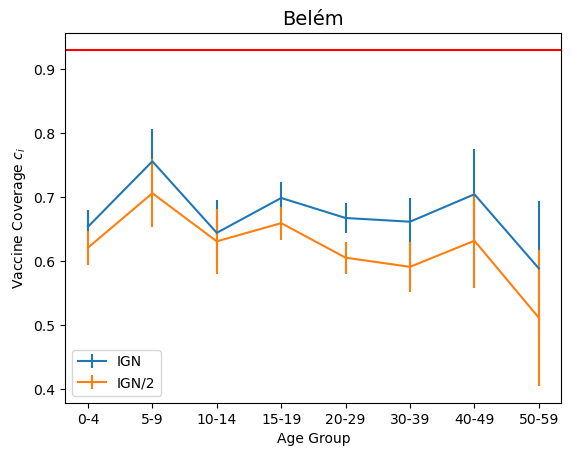

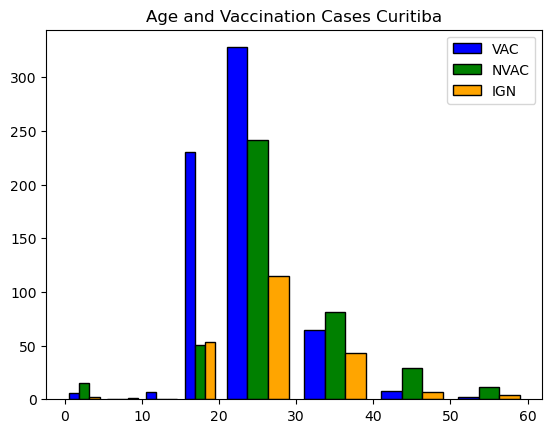

Considering ignored are vaccinated
104025.59399616637 25319.201861883004
EXCLUDING IGNORED FROM SAMPLE
158789.5020370987 41682.37682875991


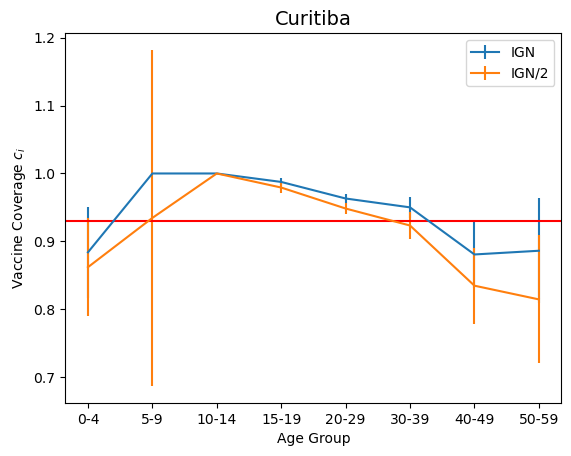

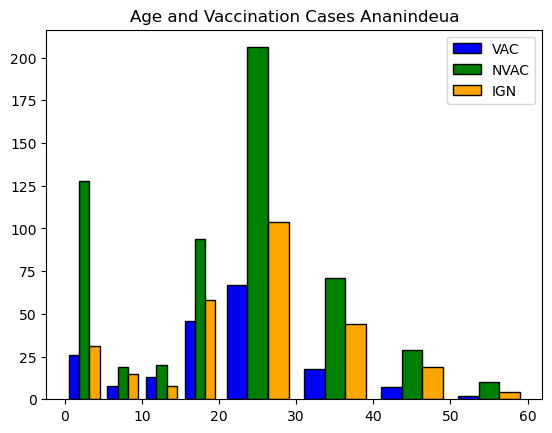

Considering ignored are vaccinated
37851.83106177498 6175.930664466054
EXCLUDING IGNORED FROM SAMPLE
65428.747211449634 7854.343243767863


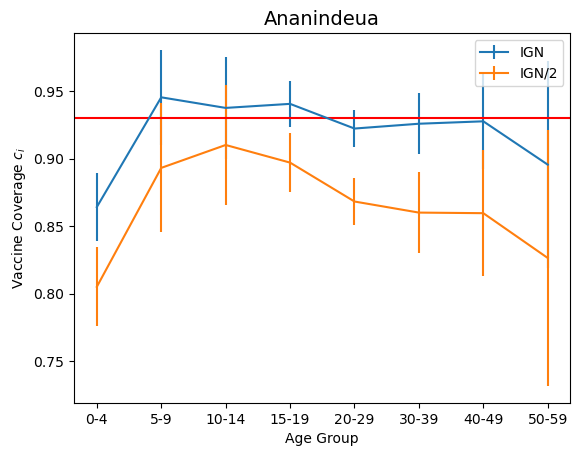

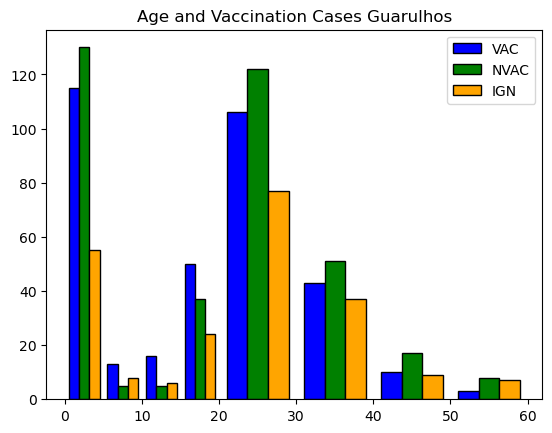

Considering ignored are vaccinated
52294.4814185994 13180.751701619993
EXCLUDING IGNORED FROM SAMPLE
89128.63089258842 17425.04762267738


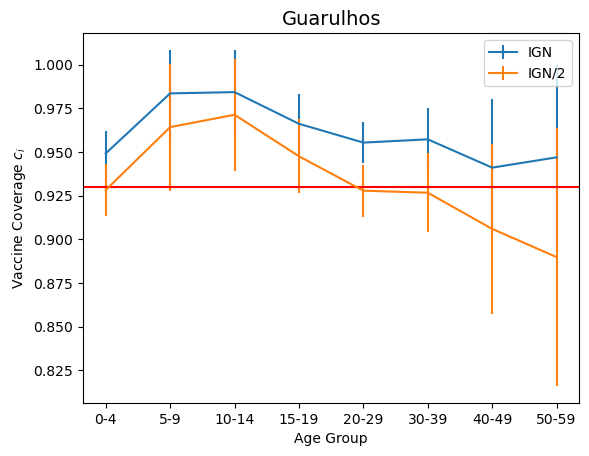

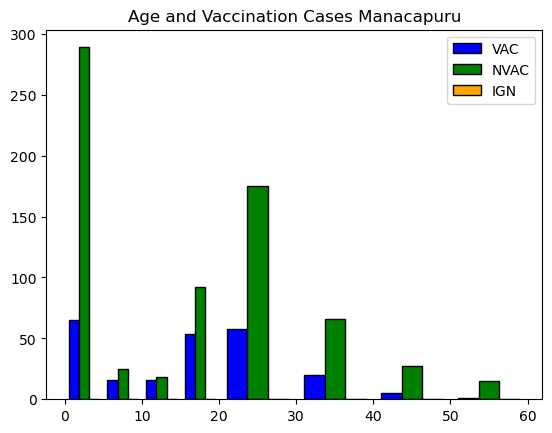

Considering ignored are vaccinated
18005.56715966841 1659.8258011490798
EXCLUDING IGNORED FROM SAMPLE
18005.56715966841 1659.8258011490798


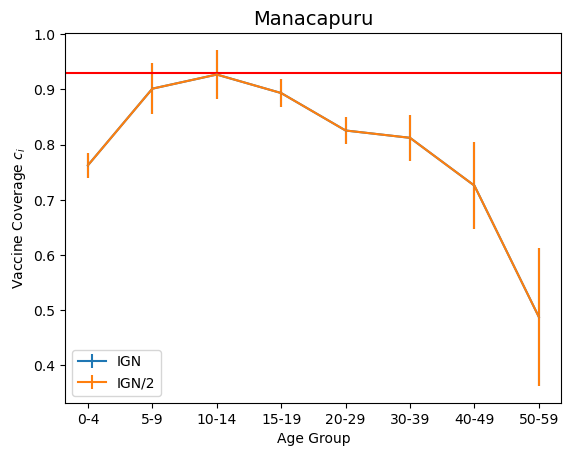

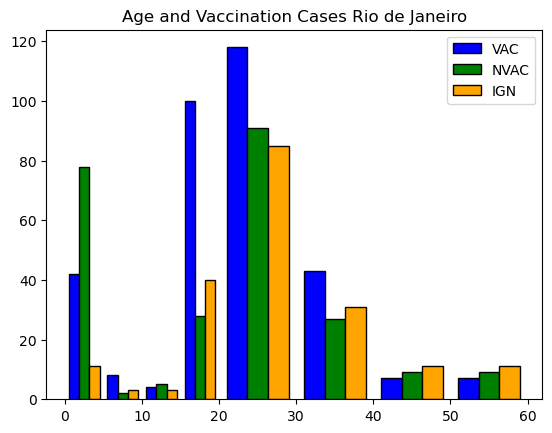

Considering ignored are vaccinated
184672.32024848505 56706.56429521576
EXCLUDING IGNORED FROM SAMPLE
336661.1909551561 79194.42446829927


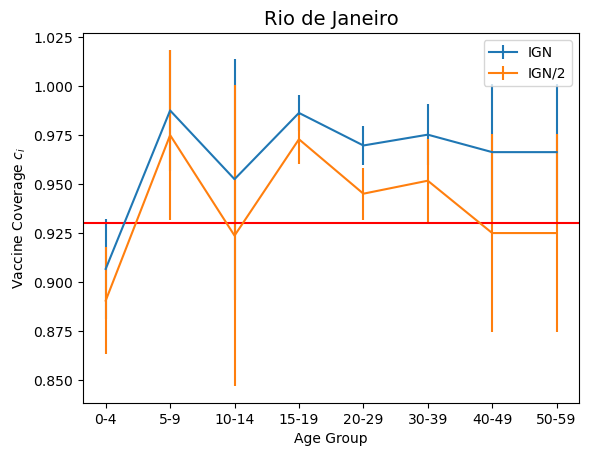

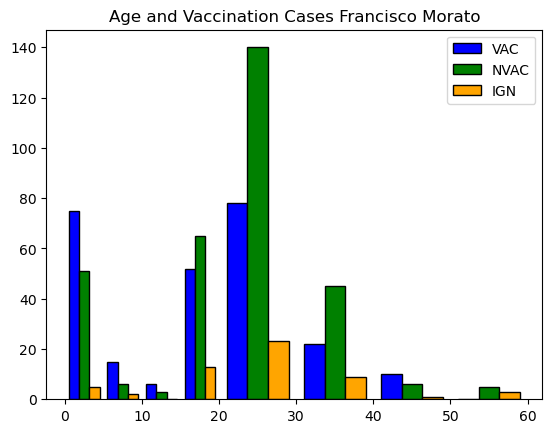

Considering ignored are vaccinated
10576.888260052858 2695.648931970835
EXCLUDING IGNORED FROM SAMPLE
14540.539977377415 3342.2496502603576


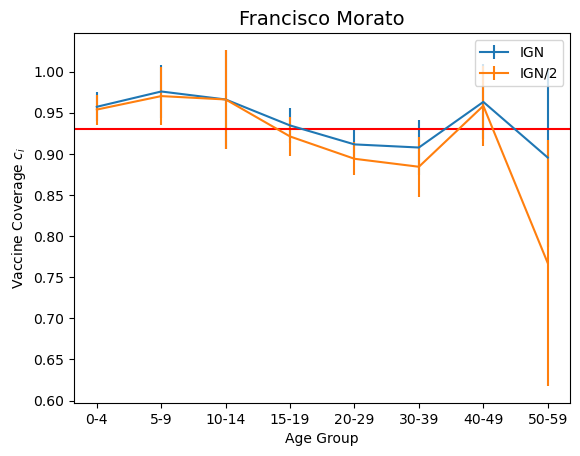

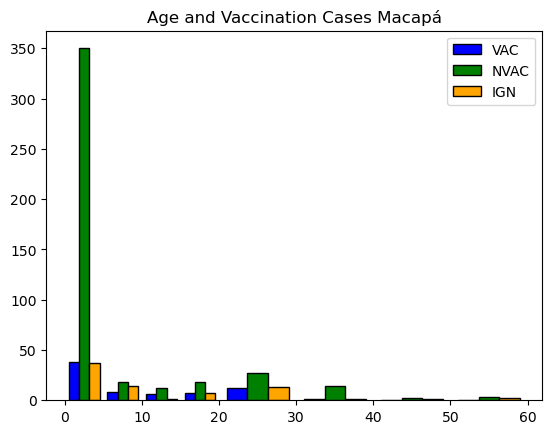

Considering ignored are vaccinated
70897.05466718944 18349.690489498462
EXCLUDING IGNORED FROM SAMPLE
104027.10591772107 22744.41948191111


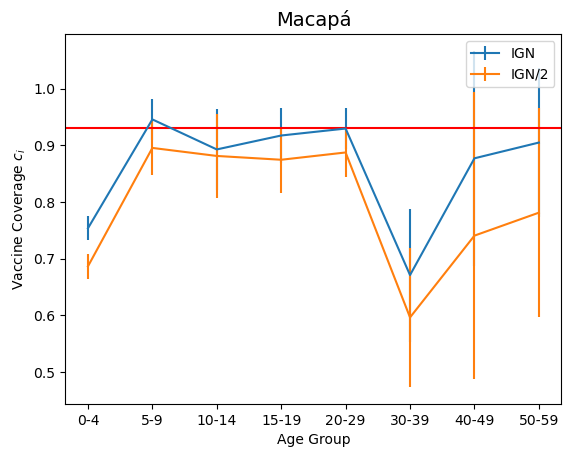

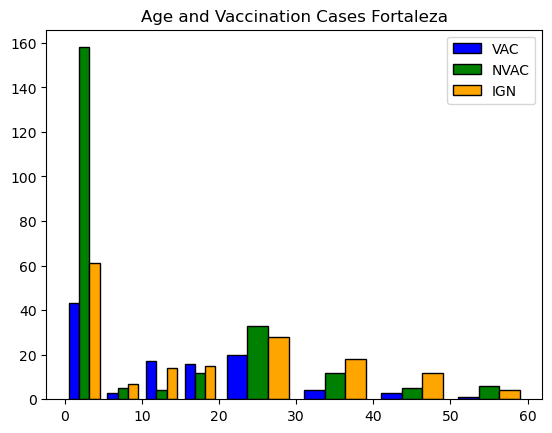

Considering ignored are vaccinated
99400.2588960441 34998.220760475066
EXCLUDING IGNORED FROM SAMPLE
222818.8867576376 52057.00407622628


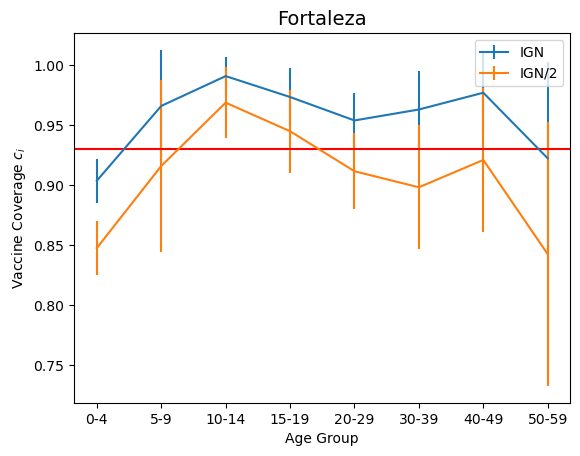

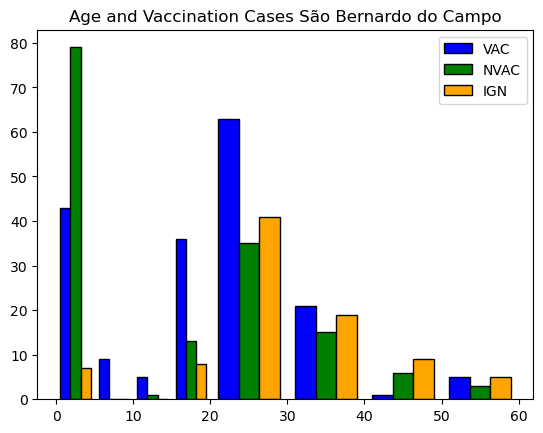

Considering ignored are vaccinated
20957.458936846397 8792.677497762546
EXCLUDING IGNORED FROM SAMPLE
41486.71727867419 13341.106349266176


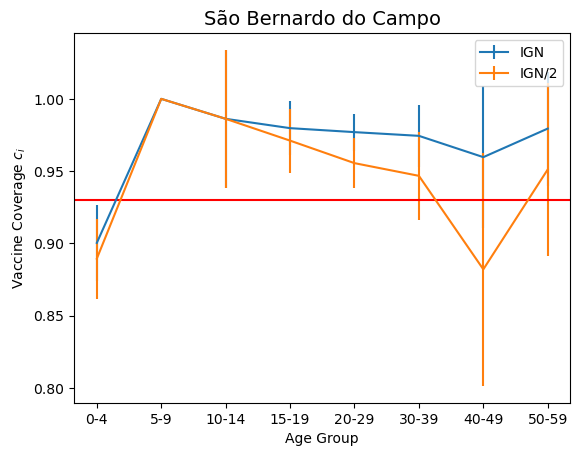

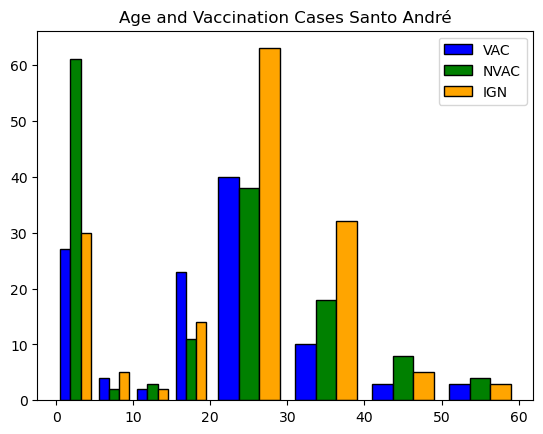

Considering ignored are vaccinated
23656.488812117746 10290.100168124074
EXCLUDING IGNORED FROM SAMPLE
48223.4283033933 13806.035279889362


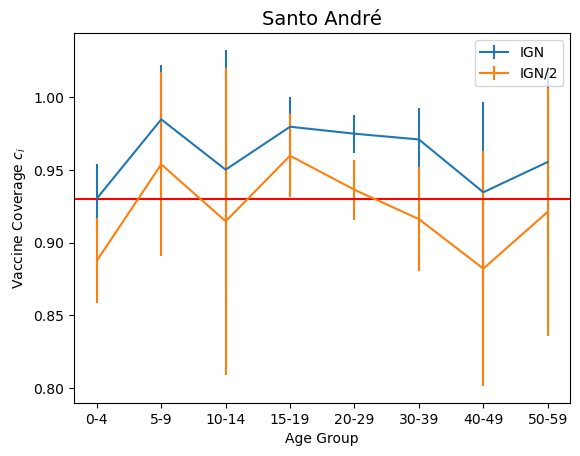

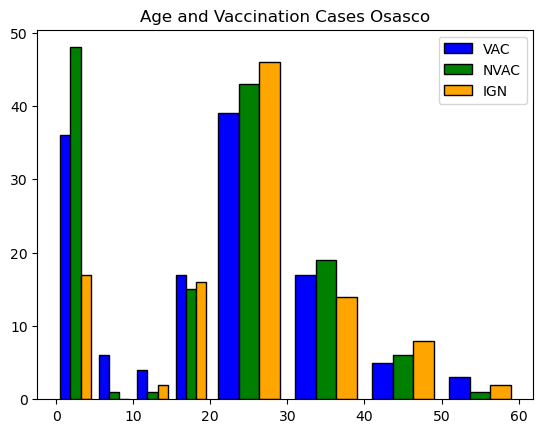

Considering ignored are vaccinated
18143.95487294792 7502.577337425882
EXCLUDING IGNORED FROM SAMPLE
34365.31119366741 10740.500198591744


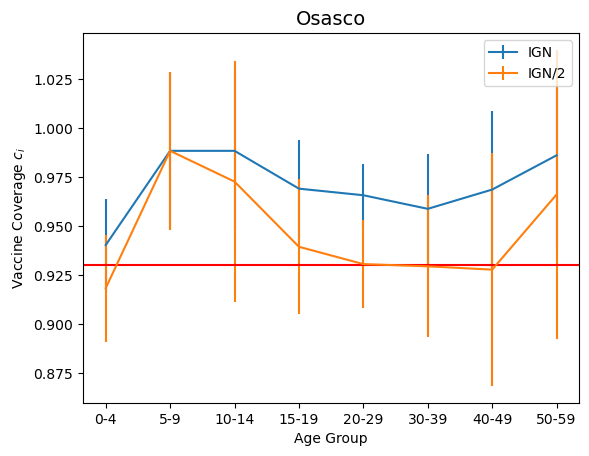

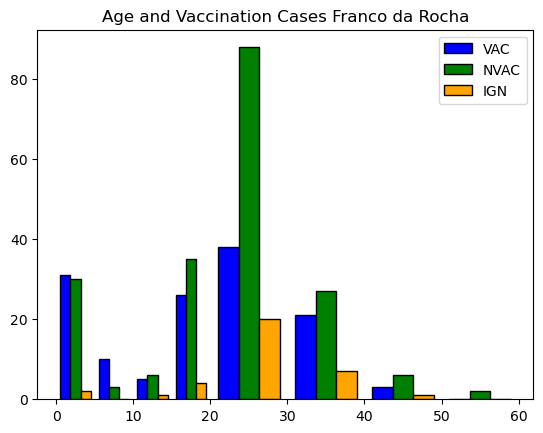

Considering ignored are vaccinated
24910.053091339272 2663.6960678854307
EXCLUDING IGNORED FROM SAMPLE
26899.088963767696 2897.487029360965


C:\Users\denise.cammarota\AppData\Local\Temp\ipykernel_22196\842528999.py:2: RuntimeWarning: divide by zero encountered in divide
  return (1 +((1-e)*((1/p) -1)))**-1


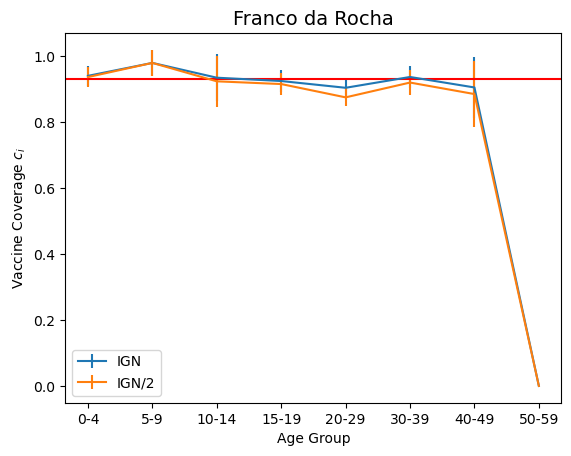

In [35]:
first_10 = [355030., 130260., 150140., 410690., 150080., 351880., 130250.,
       330455., 351630., 160030.,230440.,354870.,354780.,353440.,351640.]

# data for municipalities by age
data_muns = pd.read_csv('../Data/age_groups_municipalities.csv')


# data of cases, age and their vaccination status
df_mun = pd.read_csv('../Data/analyzed/age_vaccine_municipalities.csv')
mun_path = '../Data/municipalities.csv'
mun_file = pd.read_csv(mun_path)
mun_file['codigo'] = mun_file['municipio'].astype(str).str[:6].astype(int)
mun_file = mun_file[['municipio','name','codigo']]
df_mun = df_mun.merge(mun_file, how = 'left', left_on = 'ID_MN_RESI', right_on = 'codigo')



for mun in first_10:
    df_tmp = df_mun[df_mun['ID_MN_RESI'] == mun]
    df_tmp = df_tmp[df_tmp['NU_IDADE_N'] <= 60]
    mun_name = df_tmp['name'].unique()[0]
    min_age = 0
    max_age = 60
    colors=['blue', 'green', 'orange']
    names=['VAC', 'NVAC', 'IGN']
    x_vac = list(df_tmp[df_tmp['CS_VACINA'] == 1]['NU_IDADE_N'])
    x_nvac = list(df_tmp[df_tmp['CS_VACINA'] == 2]['NU_IDADE_N'])
    x_ign = list(df_tmp[df_tmp['CS_VACINA'] == 9]['NU_IDADE_N'])
    bins_grouped = np.array([0,5,10,15,20,30,40,50,60])
    #bins_grouped = np.array([0,5,10,15,20,30,40])
    bins = plt.hist([x_vac, x_nvac, x_ign], color=colors, label=names, bins=bins_grouped,  edgecolor = 'black')
    plt.title('Age and Vaccination Cases '+ str(mun_name))
    plt.legend()
    plt.show()
    # CONSIDERING IGNORED ARE VACCINATED
    print('Considering ignored are vaccinated')
    vacs = bins[0][0]
    nvacs = bins[0][1]
    ign = bins[0][2]
    vacs_2 = vacs.copy()
    nvacs_2 = nvacs.copy()
    ign_2 = ign.copy()
    vacs = vacs + ign
    # first we calculate the proportion of vaccinated
    N = vacs+nvacs # sample size
    p_vacs = vacs/N # proportion of sample
    # now we calculate errors for these proportions 
    e_p_vacs = np.sqrt(p_vacs*(1 - p_vacs)/N)
    # second we propagate to calculate the vaccination coverage
    eps = 0.93 # vaccine efficacy
    c_vacs = coverage_age(p_vacs,eps)
    e_c_vacs = error_coverage_age(p_vacs,eps)*e_p_vacs
    # third we calculate S0 with its corresponding error
    data_sp = data_muns[data_muns['Municipio'] == mun]
    data_sp = data_sp.to_numpy()[0]
    data_sp = data_sp[2:10]
    gap_vacs = 1 - np.array(c_vacs)
    S0 = np.sum(data_sp*gap_vacs)
    e_S0 = np.sqrt(np.sum((data_sp*e_c_vacs)**2))
    print(S0,e_S0)
    # EXCLUDING IGNORED FROM SAMPLE
    print('EXCLUDING IGNORED FROM SAMPLE')
    vacs_2 = vacs_2 + ign_2/2
    nvacs_2 = nvacs_2 + ign_2/2
    N_2 = vacs_2 + nvacs_2 # sample size
    p_vacs_2 = vacs_2/N_2 # proportion of sample
    # now we calculate errors for these proportions 
    e_p_vacs_2 = np.sqrt(p_vacs_2*(1 - p_vacs_2)/N_2)
    # second we propagate to calculate the vaccination coverage
    eps = 0.93 # vaccine efficacy
    c_vacs_2 = coverage_age(p_vacs_2,eps)
    e_c_vacs_2 = error_coverage_age(p_vacs_2,eps)*e_p_vacs_2
    # third we calculate S0 with its corresponding error
    gap_vacs_2 = 1 - np.array(c_vacs_2)
    S0_2 = np.sum(data_sp*gap_vacs_2)
    e_S0_2 = np.sqrt(np.sum((data_sp*e_c_vacs_2)**2))
    print(S0_2,e_S0_2)
    # NOW PLOTTING BOTH VACCINATION COVERAGES
    fig, ax = plt.subplots()
    ax.errorbar(np.arange(len(c_vacs)),c_vacs, yerr = e_c_vacs, label = 'IGN')
    ax.errorbar(np.arange(len(c_vacs_2)),c_vacs_2, yerr = e_c_vacs_2, label = 'IGN/2')
    ax.set_xticks(np.arange(len(p_vacs)))
    ax.set_xticklabels(['0-4','5-9','10-14','15-19', '20-29', '30-39','40-49','50-59'])
    ax.axhline(0.93,color = 'r')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Vaccine Coverage '+r'$c_i$')
    plt.title(mun_name, fontsize = 14)
    plt.legend()
    plt.show()